<a href="https://colab.research.google.com/github/SanyuktaaNath/FAAD-Files/blob/main/ELECTRICTY_ANOMALY_com.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly detection in time series

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
plt.rcParams["figure.figsize"] = (9,6)

## Read the data

The dataset can be downloaded from [GitHub](https://github.com/numenta/NAB/blob/master/data/realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv)

The labels can be obtained from [GitHub](https://github.com/numenta/NAB/blob/master/labels/combined_labels.json)

This is real-life data on CPU utilization of an EC2 instance in the AWS cloud. Data was recorded every 5 minutes, starting on February 14th at 14:30. The dataset contains 4032 data points. It is available through the Numenta Anomaly Benchmark (NAB) repository under the AGPL-3.0 license.

In [4]:
df = pd.read_csv('/gdrive/MyDrive/deeplearning/Electric_Production_outliers.csv') # Downloaded from the link above
df.head()

,DATE,IPG2211A2N
0,01-01-1985,72.5052
1,01-02-1985,70.6720
2,01-03-1985,62.4502
3,01-04-1985,57.4714
4,01-05-1985,55.3151


In [6]:
# Labels taken from the link above. We are looking at the labels for electric_production_outliers dataset

anomalies_timestamp = [
        "01-05-2017", "01-05-2013", "01-05-2016"    ]

In [7]:
df['DATE'] = pd.to_datetime(df['DATE'])

df.head()

,DATE,IPG2211A2N
0,1985-01-01,72.5052
1,1985-01-02,70.6720
2,1985-01-03,62.4502
3,1985-01-04,57.4714
4,1985-01-05,55.3151


In [8]:
df['is_anomaly'] = 1

for each in anomalies_timestamp:
    df.loc[df['DATE'] == each, 'is_anomaly'] = -1

df.head()

,DATE,IPG2211A2N,is_anomaly
0,1985-01-01,72.5052,1
1,1985-01-02,70.6720,1
2,1985-01-03,62.4502,1
3,1985-01-04,57.4714,1
4,1985-01-05,55.3151,1


In [9]:
anomaly_df = df.loc[df['is_anomaly'] == -1]
inlier_df = df.loc[df['is_anomaly'] == 1]

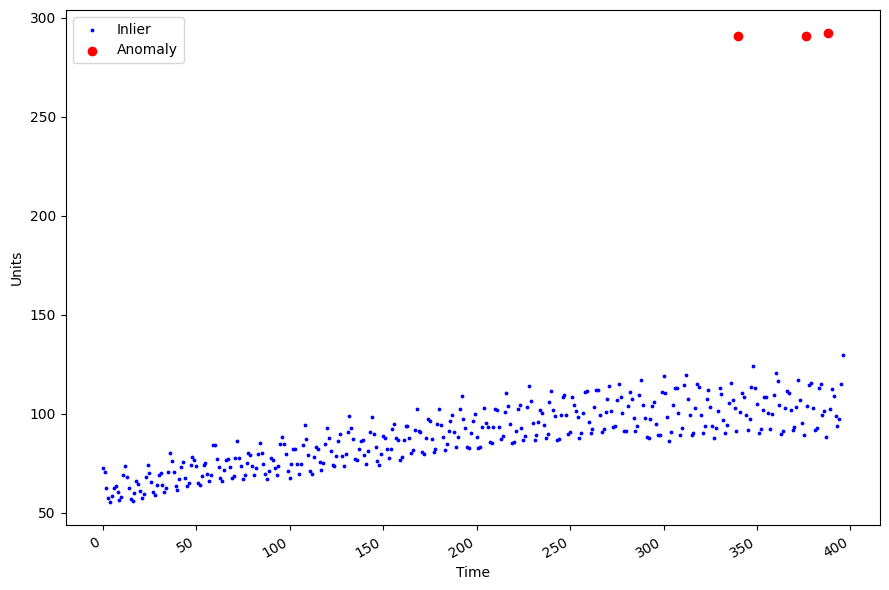

In [10]:
fig, ax = plt.subplots()

ax.scatter(inlier_df.index, inlier_df['IPG2211A2N'], color='blue', s=3, label='Inlier')
ax.scatter(anomaly_df.index, anomaly_df['IPG2211A2N'], color='red', label='Anomaly')
ax.set_xlabel('Time')
ax.set_ylabel('Units')
ax.legend(loc=2)

plt.grid(False)
fig.autofmt_xdate()
plt.tight_layout()

## Baseline: median absolute deviation (MAD)

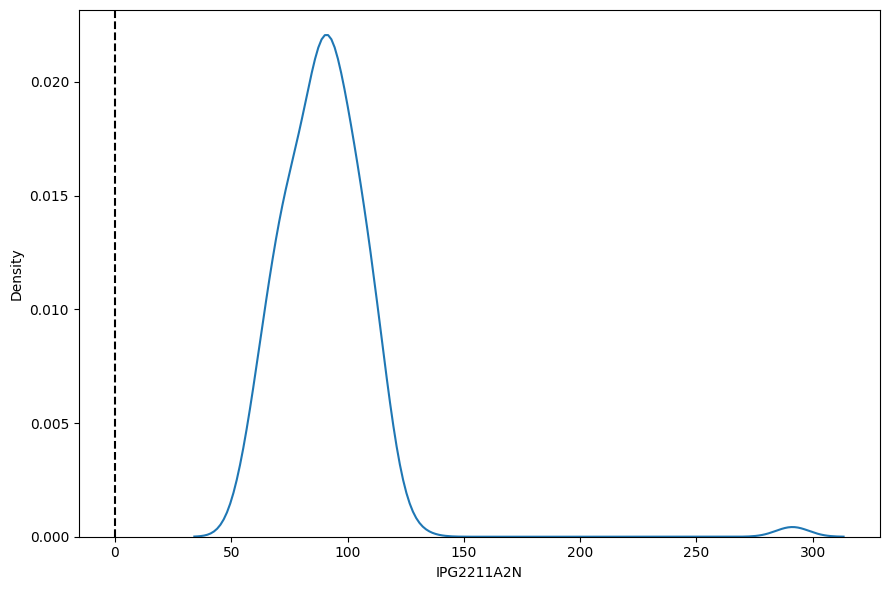

In [11]:
import seaborn as sns

sns.kdeplot(df['IPG2211A2N']);
plt.grid(False)
plt.axvline(0.134, 0, 1, c='black', ls='--')
plt.tight_layout()

In [12]:
from scipy.stats import median_abs_deviation

mad = median_abs_deviation(df['IPG2211A2N'])
median = np.median(df['IPG2211A2N'])

print(median)
print(mad)

def compute_robust_z_score(x):
    return .6745*(x-median)/mad

89.7795
12.015299999999996


In [13]:
df['z-score'] = df['IPG2211A2N'].apply(compute_robust_z_score)

df.head()

,DATE,IPG2211A2N,is_anomaly,z-score
0,1985-01-01,72.5052,1,-0.969723
1,1985-01-02,70.6720,1,-1.072633
2,1985-01-03,62.4502,1,-1.534178
3,1985-01-04,57.4714,1,-1.813672
4,1985-01-05,55.3151,1,-1.934720


In [14]:
df['baseline'] = 1

df.loc[df['z-score'] >= 3.5, 'baseline'] = -1
df.loc[df['z-score'] <=-3.5, 'baseline'] = -1

### Evaluation

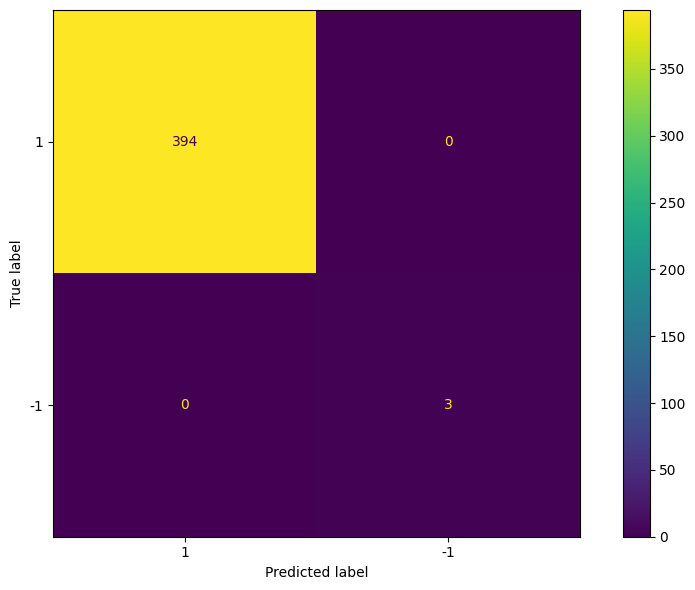

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df['is_anomaly'], df['baseline'], labels=[1, -1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

disp_cm.plot();

plt.grid(False)
plt.tight_layout()

## Isolation forest

In [16]:
from sklearn.ensemble import IsolationForest

In [17]:
train = df[:279]
test = df[119:]

In [18]:
#contamination = 1/len(train)

iso_forest = IsolationForest(contamination=0.01, random_state=42)

X_train = train['IPG2211A2N'].values.reshape(-1,1)

iso_forest.fit(X_train)

IsolationForest(contamination=0.01, random_state=42)

In [19]:
preds_iso_forest = iso_forest.predict(test['IPG2211A2N'].values.reshape(-1,1))

### Evaluation

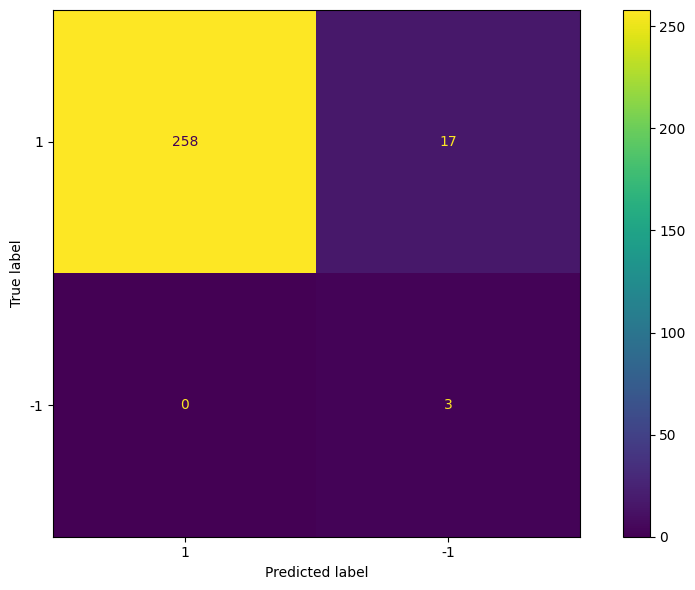

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test['is_anomaly'], preds_iso_forest, labels=[1, -1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

disp_cm.plot();

plt.grid(False)
plt.tight_layout()

## Local outlier factor (LOF)

In [21]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(contamination=0.01, novelty=True)

lof.fit(X_train)

LocalOutlierFactor(contamination=0.01, novelty=True)

In [22]:
preds_lof = lof.predict(test['IPG2211A2N'].values.reshape(-1,1))

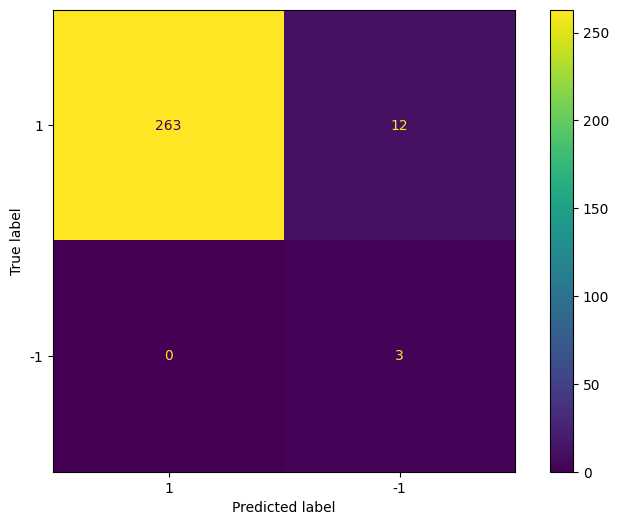

In [23]:
cm = confusion_matrix(test['is_anomaly'], preds_lof, labels=[1, -1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

disp_cm.plot();